<a href="https://colab.research.google.com/github/HongEnJung/PROJECT/blob/main/Food_delivery_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 배달 도착시간 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기 및 탐색

In [ ]:
import pandas as pd
fd=pd.read_csv("/content/drive/MyDrive/Food_delivery.csv")

In [ ]:
fd.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [ ]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio



```
ID: 고유 식별자
Delivery_person_ID: 배송원 식별자
Delivery_person_Age: 배송원 나이
Delivery_person_Ratings: 배송원 평점
Restaurant_latitude: 음식점 위도
Restaurant_longitude: 음식점 경도
Delivery_location_latitude: 배송 위치 위도
Delivery_location_longitude: 배송 위치 경도
Order_Date: 주문 날짜
Time_Ordered: 주문 시간
Time_Order_picked: 주문 픽업 시간
Weather_conditions: 날씨 조건
Road_traffic_density: 도로 교통 밀도
Vehicle_condition: 배송용 차량 상태
Type_of_order: 주문 유형
Type_of_vehicle: 배송용 차량 유형
Multiple_deliveries: 다중 배송 여부
Festival: 축제 여부
City: 도시
Time_taken(min): 배송 시간 (분)
```



In [ ]:
fd.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [ ]:
fd.describe(include="O").T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


# 데이터 전처리 및 시각화

In [ ]:
fd.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [ ]:
fd['Festival'].unique()

array(['No ', 'Yes ', 'NaN '], dtype=object)

In [ ]:
# Delivery_person_Age, Delivery_person_Ratings, multiple_deliveries float 변환
t = ['Delivery_person_Age', 'Delivery_person_Ratings', 'multiple_deliveries']

for i in t:
  fd[i] = fd[i].astype(float)
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          43739 non-null  float64
 3   Delivery_person_Ratings      43685 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [ ]:
fd['y'] = fd['Time_taken(min)'].str.split(' ').str[1]
fd['Weather'] = fd['Weatherconditions'].str.split(' ').str[1]

In [ ]:
fd['y']=fd['y'].astype(int)

In [ ]:
fd=fd.drop(['Time_taken(min)', 'Weatherconditions', 'ID'], axis=1)

In [ ]:
fd.shape

(45593, 19)

In [ ]:
fd['Time_Orderd'] = pd.to_timedelta(fd['Time_Orderd'], errors='coerce')
fd['Time_Order_picked'] =  pd.to_timedelta(fd['Time_Order_picked'],  errors='coerce')

In [ ]:
fd = fd.dropna(subset=['Time_Orderd'])
fd = fd.dropna(subset=['Time_Order_picked'])

In [ ]:
fd['Order_Date'] =pd.to_datetime(fd['Order_Date'])

In [ ]:
fd['Time_Orderd_Hours'] = fd['Time_Orderd'].dt.components['hours']

In [ ]:
# 거리 구하기
!pip install geopy

In [ ]:
from geopy.distance import distance

def calculate_distance(row):
    restaurant_coord = (row['Restaurant_latitude'], row['Restaurant_longitude'])
    delivery_coord = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])

    return distance(restaurant_coord, delivery_coord).km

In [ ]:
fd['distance'] = fd.apply(calculate_distance, axis=1)
fd['distance'] = round(fd['distance'],0)

In [ ]:
fd[fd['distance']>100]

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,y,Weather,Time_Orderd_Hours,distance
92,AGRRES010DEL01,34.0,4.7,-27.163303,78.057044,27.233303,78.127044,2022-02-16,0 days 23:00:00,0 days 23:05:00,...,1,Drinks,scooter,0.0,No,Metropolitian,15,Sandstorms,23,6019.0
283,AGRRES12DEL03,32.0,4.7,-27.165108,78.015053,27.225108,78.075053,2022-02-13,0 days 20:55:00,0 days 21:10:00,...,2,Meal,scooter,1.0,No,Metropolitian,31,Sandstorms,20,6019.0
1091,GOARES010DEL03,20.0,4.7,-15.546594,73.760431,15.606594,73.820431,2022-02-13,0 days 20:00:00,0 days 20:10:00,...,2,Drinks,motorcycle,1.0,No,Metropolitian,29,Cloudy,20,3446.0
1783,BHPRES13DEL02,39.0,4.5,-23.230791,77.437020,23.250791,77.457020,2022-02-13,0 days 09:15:00,0 days 09:20:00,...,0,Meal,motorcycle,1.0,No,Metropolitian,29,Cloudy,9,5142.0
1976,KOLRES16DEL01,25.0,4.0,-22.539129,88.365507,22.549129,88.375507,2022-02-15,0 days 09:25:00,0 days 09:30:00,...,0,Buffet,motorcycle,0.0,No,Metropolitian,19,Sandstorms,9,4988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43860,GOARES16DEL01,32.0,4.6,-15.498603,73.826911,15.568603,73.896911,2022-02-18,0 days 23:10:00,0 days 23:15:00,...,0,Snack,motorcycle,1.0,No,Metropolitian,24,Sandstorms,23,3436.0
44051,GOARES14DEL03,22.0,5.0,-15.157944,73.950889,15.217944,74.010889,2022-02-17,0 days 18:50:00,0 days 18:55:00,...,1,Buffet,scooter,1.0,No,Metropolitian,27,Sandstorms,18,3360.0
44640,KOCRES06DEL03,23.0,4.8,-9.982834,76.283268,10.072834,76.373268,2022-02-14,0 days 19:20:00,0 days 19:35:00,...,0,Drinks,motorcycle,1.0,No,Metropolitian,21,Sunny,19,2218.0
44933,AURGRES03DEL03,30.0,4.9,-19.874733,75.353942,19.904733,75.383942,2022-02-15,0 days 22:20:00,0 days 22:35:00,...,1,Buffet,motorcycle,0.0,No,Metropolitian,15,Fog,22,4400.0


In [ ]:
fd.drop(fd[fd['distance'] >100].index, axis=0,inplace=True)
fd.shape

(43706, 21)

In [ ]:
fd.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'] , axis=1, inplace=True)

In [ ]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43706 entries, 0 to 45592
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   Delivery_person_ID       43706 non-null  object         
 1   Delivery_person_Age      43492 non-null  float64        
 2   Delivery_person_Ratings  43443 non-null  float64        
 3   Order_Date               43706 non-null  datetime64[ns] 
 4   Time_Orderd              43706 non-null  timedelta64[ns]
 5   Time_Order_picked        43706 non-null  timedelta64[ns]
 6   Road_traffic_density     43706 non-null  object         
 7   Vehicle_condition        43706 non-null  int64          
 8   Type_of_order            43706 non-null  object         
 9   Type_of_vehicle          43706 non-null  object         
 10  multiple_deliveries      42765 non-null  float64        
 11  Festival                 43706 non-null  object         
 12  City              

In [ ]:
fd.describe(include="O").T

,count,unique,top,freq
Delivery_person_ID,43706,1320,PUNERES01DEL01,65
Road_traffic_density,43706,4,Low,15003
Type_of_order,43706,4,Snack,11058
Type_of_vehicle,43706,3,motorcycle,25537
Festival,43706,3,No,42630
City,43706,4,Metropolitian,32690
Weather,43706,6,Fog,7451


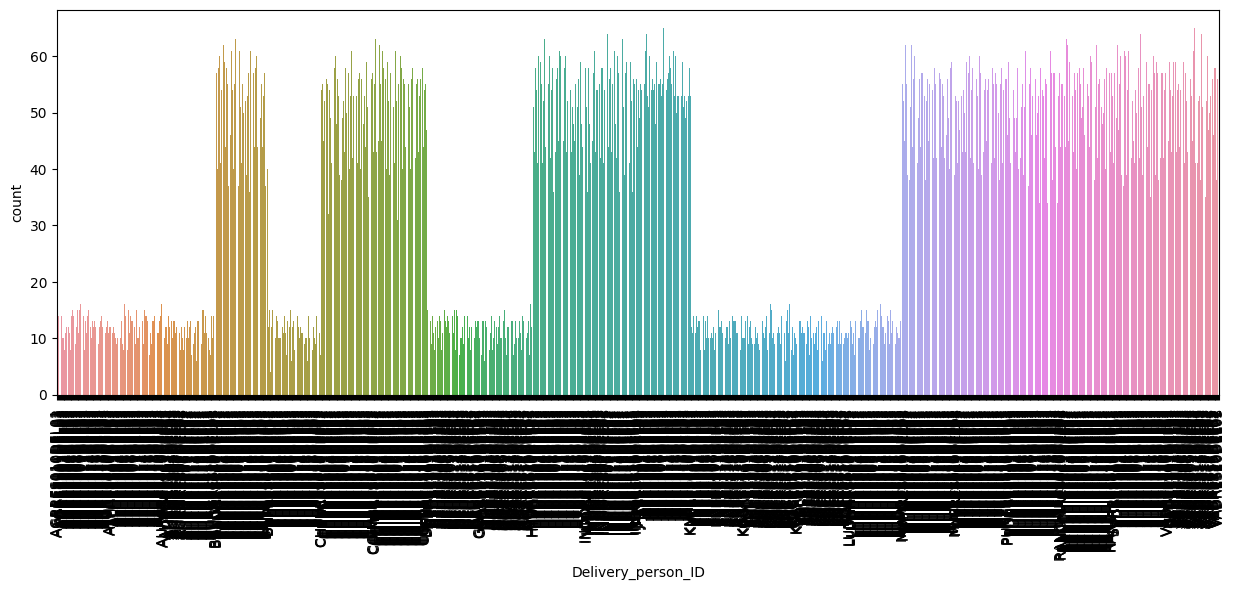

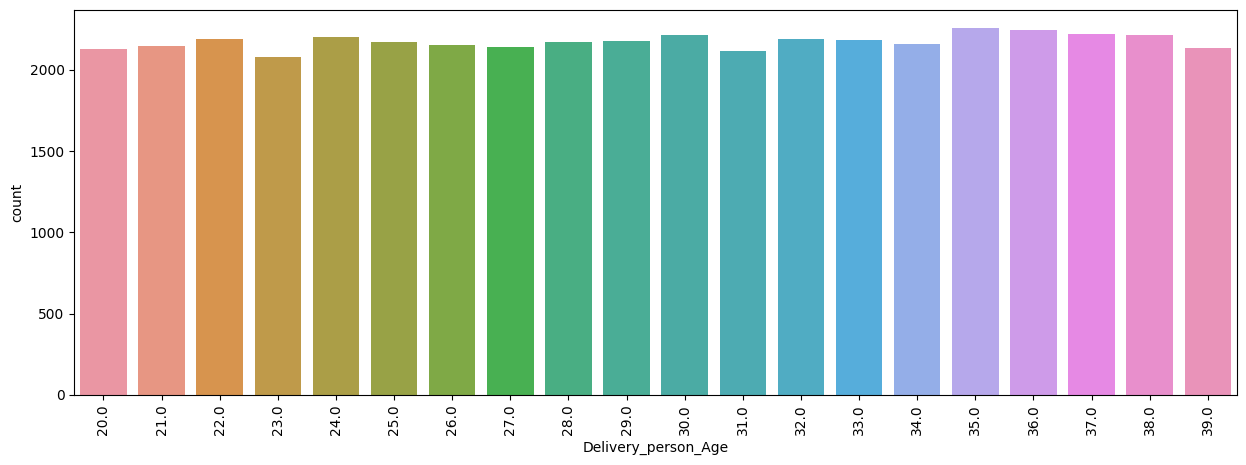

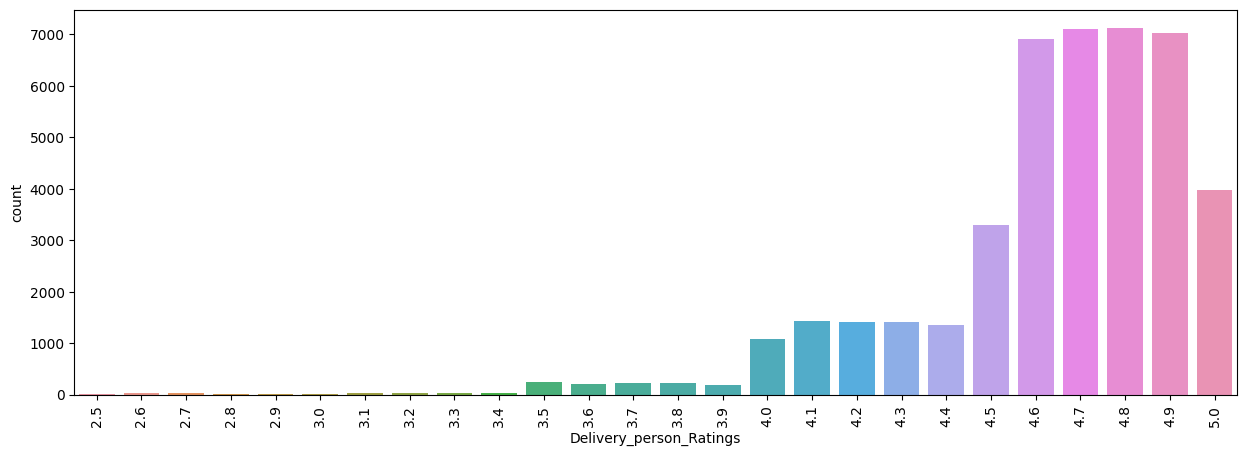

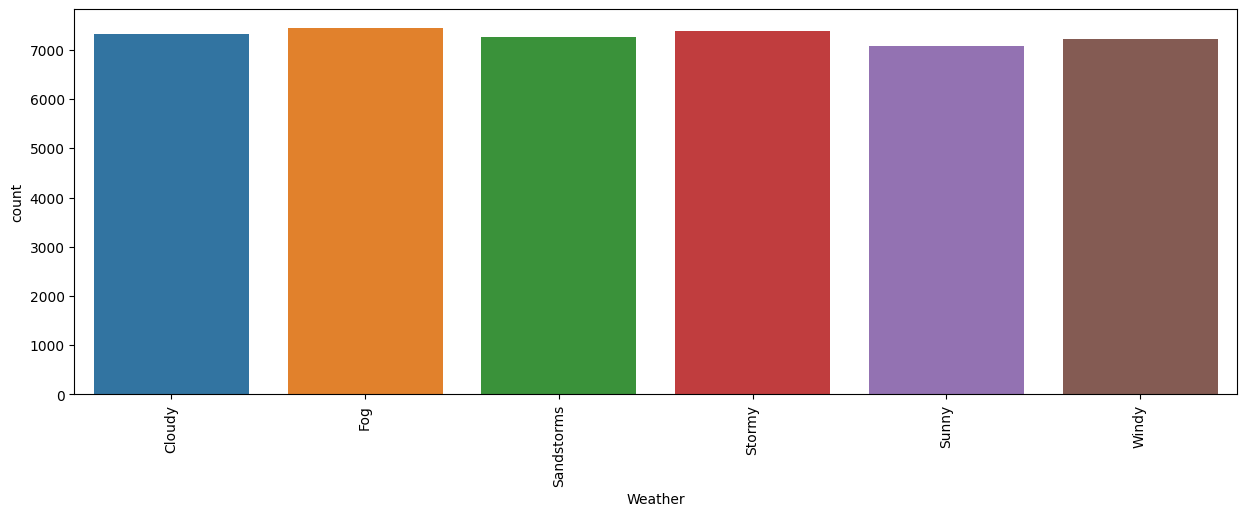

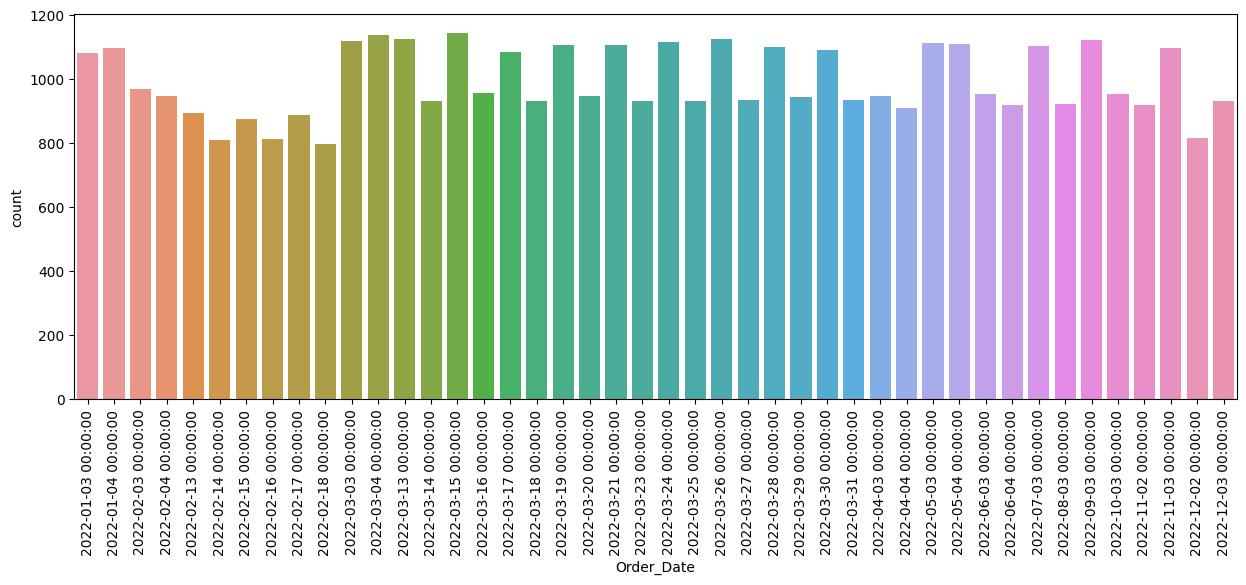

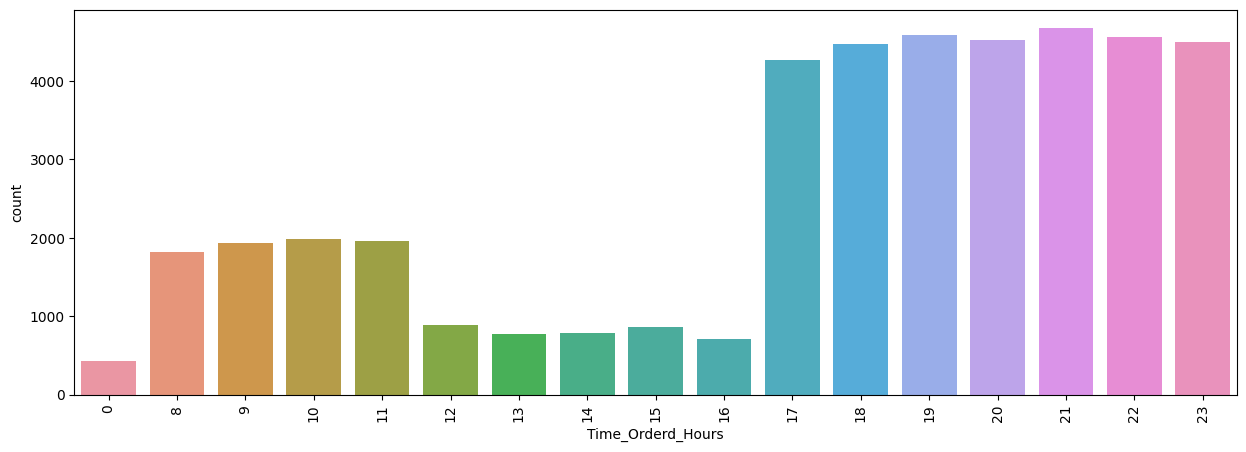

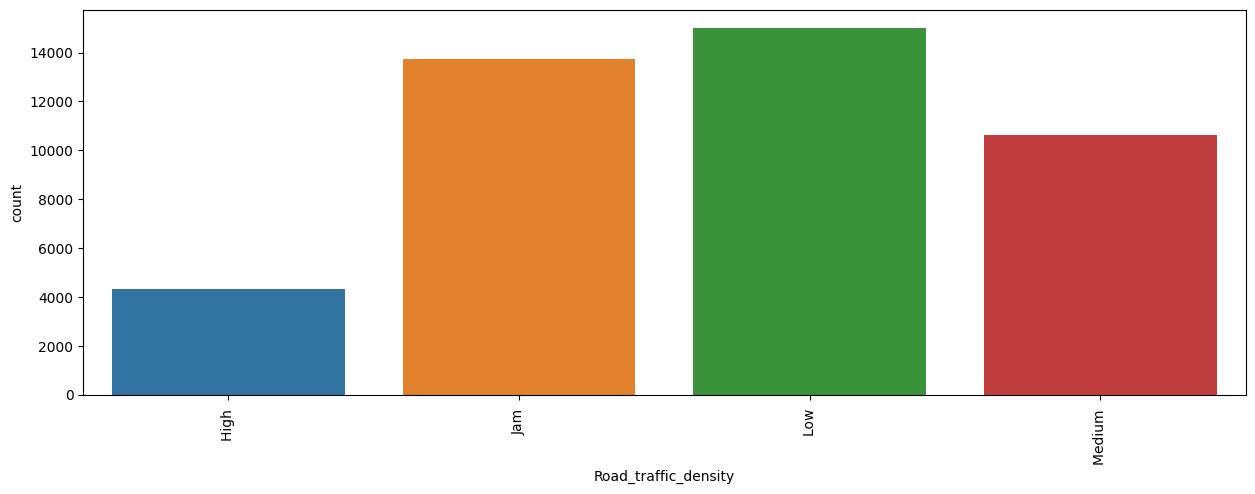

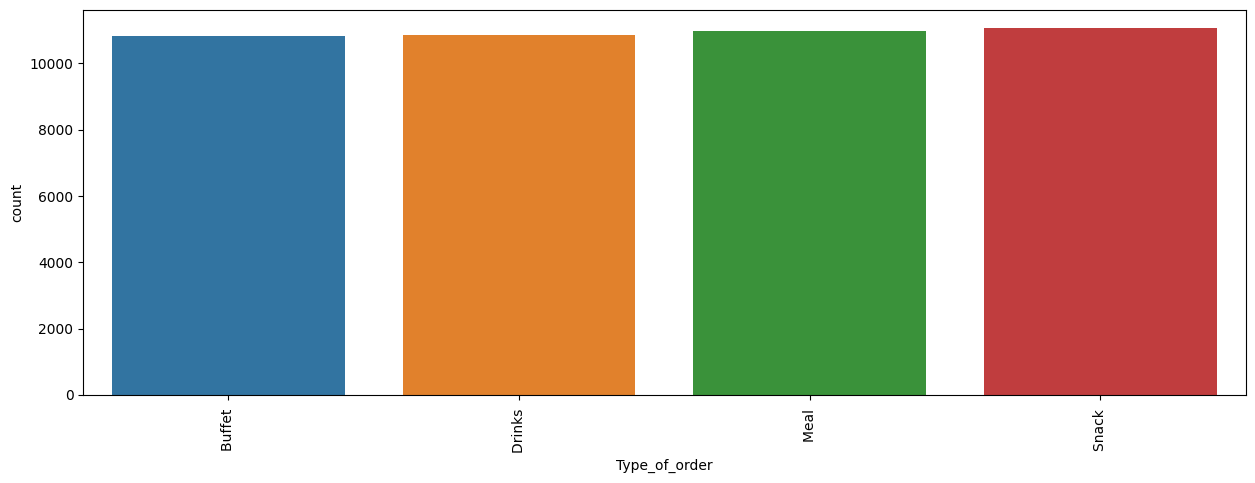

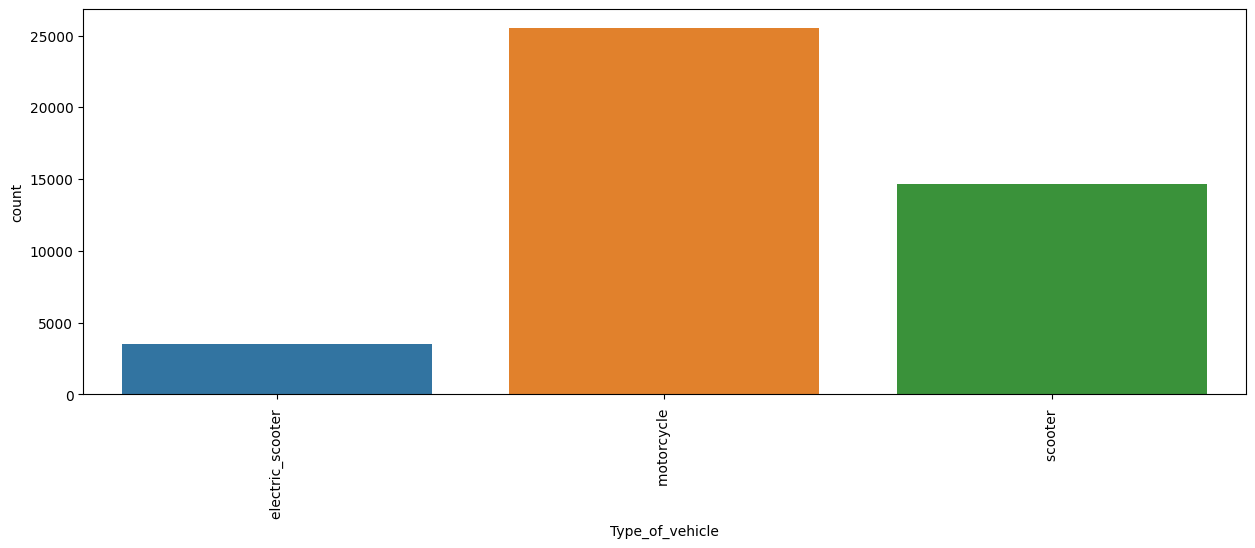

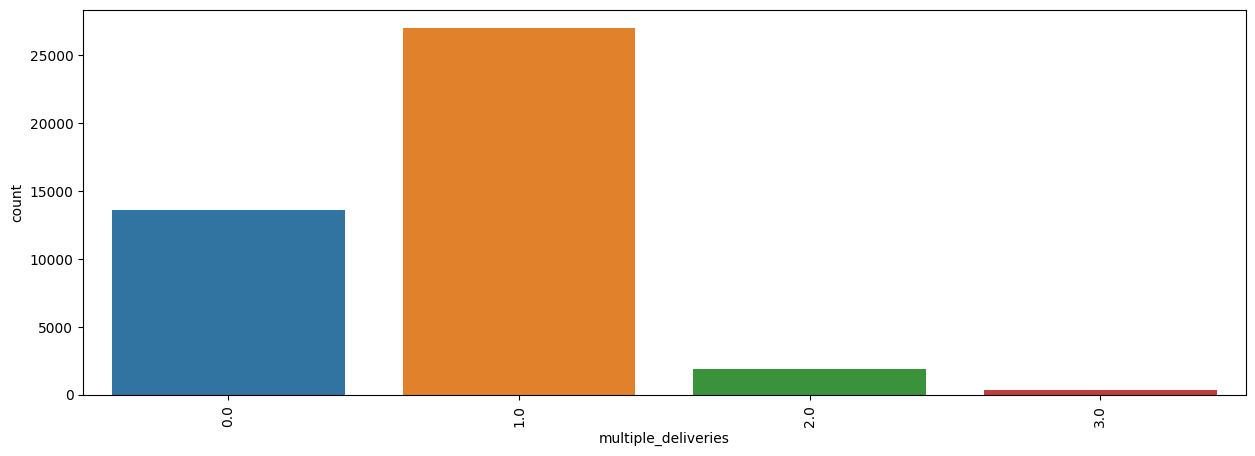

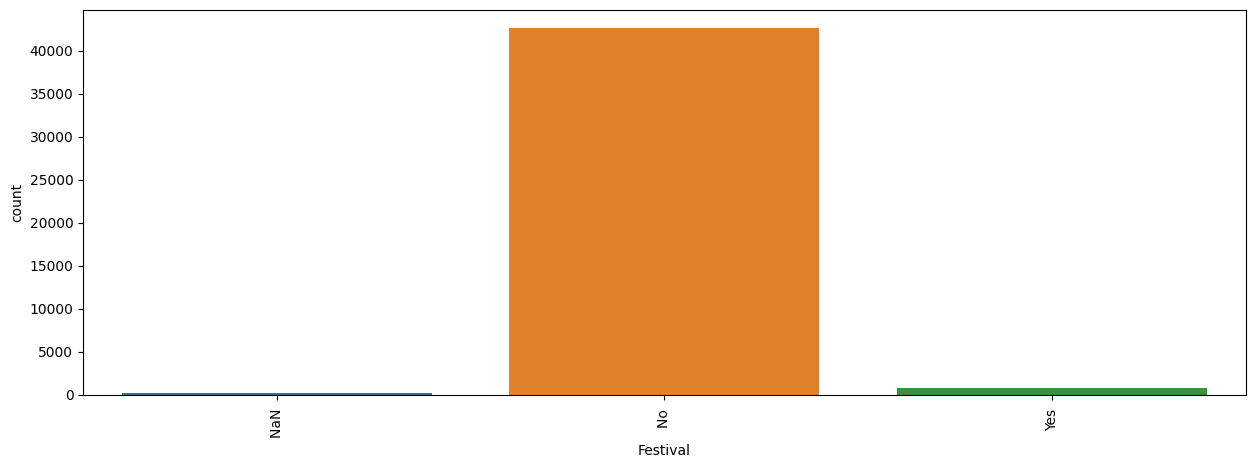

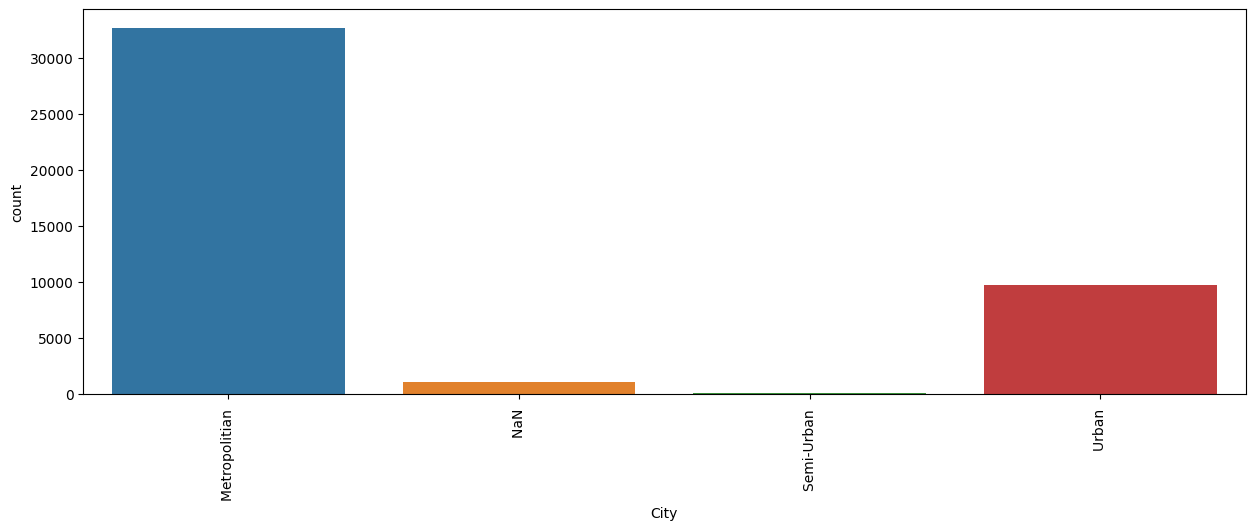

In [ ]:
features=['Delivery_person_ID','Delivery_person_Age', 'Delivery_person_Ratings', 'Weather','Order_Date', 'Time_Orderd_Hours', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries',  'Festival', 'City']
#plt.figure(figsize=(15, 8))

for i, column_name in enumerate(features):
    plt.figure(figsize=(15, 5))
    sns.countplot(data=fd, x=column_name, order=fd[column_name].value_counts().sort_index().index)
    plt.xticks(rotation=90)  # x축 레이블 90도 회전
    plt.show()

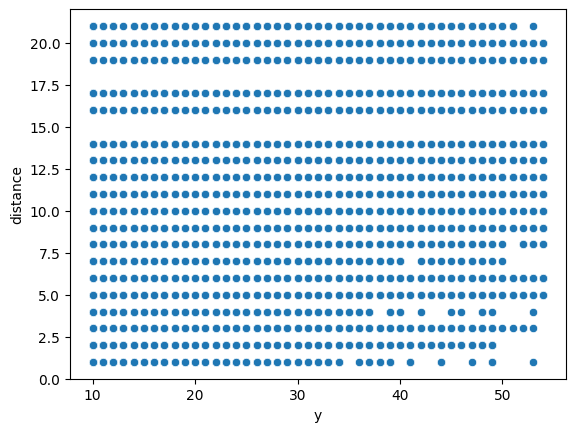

In [ ]:
# 산점도 그리기
sns.scatterplot(data=fd, x='y', y='distance')

# 그래프 표시
plt.show()

## 데이터 인코딩

In [ ]:
fd = pd.get_dummies(fd, columns=['Road_traffic_density','Type_of_order', 'Type_of_vehicle', 'Festival', 'City' , 'Weather'])
fd

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Time_Orderd,Time_Order_picked,Vehicle_condition,multiple_deliveries,y,Time_Orderd_Hours,...,City_Metropolitian,City_NaN,City_Semi-Urban,City_Urban,Weather_Cloudy,Weather_Fog,Weather_Sandstorms,Weather_Stormy,Weather_Sunny,Weather_Windy
0,INDORES13DEL02,37.0,4.9,2022-03-19,0 days 11:30:00,0 days 11:45:00,2,0.0,24,11,...,0,0,0,1,0,0,0,0,1,0
1,BANGRES18DEL02,34.0,4.5,2022-03-25,0 days 19:45:00,0 days 19:50:00,2,1.0,33,19,...,1,0,0,0,0,0,0,1,0,0
2,BANGRES19DEL01,23.0,4.4,2022-03-19,0 days 08:30:00,0 days 08:45:00,0,1.0,26,8,...,0,0,0,1,0,0,1,0,0,0
3,COIMBRES13DEL02,38.0,4.7,2022-05-04,0 days 18:00:00,0 days 18:10:00,0,1.0,21,18,...,1,0,0,0,0,0,0,0,1,0
4,CHENRES12DEL01,32.0,4.6,2022-03-26,0 days 13:30:00,0 days 13:45:00,1,1.0,30,13,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,JAPRES04DEL01,30.0,4.8,2022-03-24,0 days 11:35:00,0 days 11:45:00,1,0.0,32,11,...,1,0,0,0,0,0,0,0,0,1
45589,AGRRES16DEL01,21.0,4.6,2022-02-16,0 days 19:55:00,0 days 20:10:00,0,1.0,36,19,...,1,0,0,0,0,0,0,0,0,1
45590,CHENRES08DEL03,30.0,4.9,2022-11-03,0 days 23:50:00,0 days 00:05:00,1,0.0,16,23,...,1,0,0,0,1,0,0,0,0,0
45591,COIMBRES11DEL01,20.0,4.7,2022-07-03,0 days 13:35:00,0 days 13:40:00,0,1.0,26,13,...,1,0,0,0,1,0,0,0,0,0




```
from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Delivery_person_ID','Road_traffic_density','Type_of_order', 'Type_of_vehicle', 'Festival', 'City' , 'Weather']
  for i in features:
    le= preprocessing.LabelEncoder()
    le=le.fit(dataDF[i])
    dataDF[i] = le.transform(dataDF[i])
  return dataDF

fd = encode_features(fd)
fd.head()
```



In [ ]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43706 entries, 0 to 45592
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   Delivery_person_ID                 43706 non-null  object         
 1   Delivery_person_Age                43492 non-null  float64        
 2   Delivery_person_Ratings            43443 non-null  float64        
 3   Order_Date                         43706 non-null  datetime64[ns] 
 4   Time_Orderd                        43706 non-null  timedelta64[ns]
 5   Time_Order_picked                  43706 non-null  timedelta64[ns]
 6   Vehicle_condition                  43706 non-null  int64          
 7   multiple_deliveries                42765 non-null  float64        
 8   y                                  43706 non-null  int64          
 9   Time_Orderd_Hours                  43706 non-null  int64          
 10  distance              

## 상관관계 확인

In [ ]:
fd.corr()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,multiple_deliveries,y,Time_Orderd_Hours,distance,Road_traffic_density_High,Road_traffic_density_Jam,Road_traffic_density_Low,...,City_Metropolitian,City_NaN,City_Semi-Urban,City_Urban,Weather_Cloudy,Weather_Fog,Weather_Sandstorms,Weather_Stormy,Weather_Sunny,Weather_Windy
Delivery_person_Age,1.000000,-0.117421,-0.001859,0.117826,0.304119,-0.000163,-0.001477,0.004301,0.000529,-0.000022,...,0.065619,-0.022835,0.030945,-0.064143,0.004664,-0.010311,-0.000803,0.005176,0.005033,-0.003655
Delivery_person_Ratings,-0.117421,1.000000,0.048977,-0.126528,-0.360804,-0.061527,-0.108182,0.020358,-0.085046,0.028390,...,-0.060698,0.016037,-0.027036,0.061057,0.025021,0.027181,-0.030581,-0.029977,0.033743,-0.025235
Vehicle_condition,-0.001859,0.048977,1.000000,-0.101938,-0.243006,0.002547,0.007934,-0.000945,0.010877,-0.010839,...,-0.040415,0.015148,-0.057380,0.044619,0.000286,0.002736,-0.005810,0.007388,0.000607,-0.005290
multiple_deliveries,0.117826,-0.126528,-0.101938,1.000000,0.387706,0.067864,0.127135,0.015359,0.136786,-0.145948,...,0.067396,-0.026074,0.077830,-0.071696,0.047302,0.050860,-0.016256,-0.004768,-0.073182,-0.005481
y,0.304119,-0.360804,-0.243006,0.387706,1.000000,0.184588,0.322172,0.031891,0.351510,-0.386983,...,0.186830,-0.073597,0.149612,-0.188310,0.126380,0.127899,-0.019131,-0.021139,-0.208869,-0.008844
Time_Orderd_Hours,-0.000163,-0.061527,0.002547,0.067864,0.184588,1.000000,0.579411,-0.358460,0.375955,-0.128053,...,0.038445,0.001133,0.020622,-0.043533,0.004576,-0.001552,0.004890,-0.002990,-0.006360,0.001398
distance,-0.001477,-0.108182,0.007934,0.127135,0.322172,0.579411,1.000000,-0.320876,0.283336,-0.198776,...,0.059565,-0.015607,0.034932,-0.061218,0.006070,0.002311,-0.002830,0.001157,-0.009099,0.002253
Road_traffic_density_High,0.004301,0.020358,-0.000945,0.015359,0.031891,-0.358460,-0.320876,1.000000,-0.223981,-0.238978,...,0.010976,-0.007891,0.000816,-0.008551,0.000304,0.004305,-0.007349,-0.002444,0.004319,0.000878
Road_traffic_density_Jam,0.000529,-0.085046,0.010877,0.136786,0.351510,0.375955,0.283336,-0.223981,1.000000,-0.489896,...,0.056671,-0.023805,0.066846,-0.059631,-0.002879,0.003588,0.004775,-0.008321,0.000595,0.002280
Road_traffic_density_Low,-0.000022,0.028390,-0.010839,-0.145948,-0.386983,-0.128053,-0.198776,-0.238978,-0.489896,1.000000,...,-0.077194,0.036063,-0.043271,0.072978,0.002062,-0.004961,0.003959,0.011405,-0.003795,-0.008753


In [ ]:
lm_features =['Delivery_person_Age', 'Delivery_person_Ratings','Vehicle_condition',
       'multiple_deliveries', 'Time_Orderd_Hours', 'distance',
       'Road_traffic_density_High ', 'Road_traffic_density_Jam ',
       'Road_traffic_density_Low ', 'Road_traffic_density_Medium ',
       'Type_of_order_Buffet ', 'Type_of_order_Drinks ', 'Type_of_order_Meal ',
       'Type_of_order_Snack ', 'Type_of_vehicle_electric_scooter ',
       'Type_of_vehicle_motorcycle ', 'Type_of_vehicle_scooter ',
       'Festival_NaN ', 'Festival_No ', 'Festival_Yes ', 'City_Metropolitian ',
       'City_NaN ', 'City_Semi-Urban ', 'City_Urban ', 'Weather_Cloudy',
       'Weather_Fog', 'Weather_Sandstorms', 'Weather_Stormy', 'Weather_Sunny',
       'Weather_Windy']

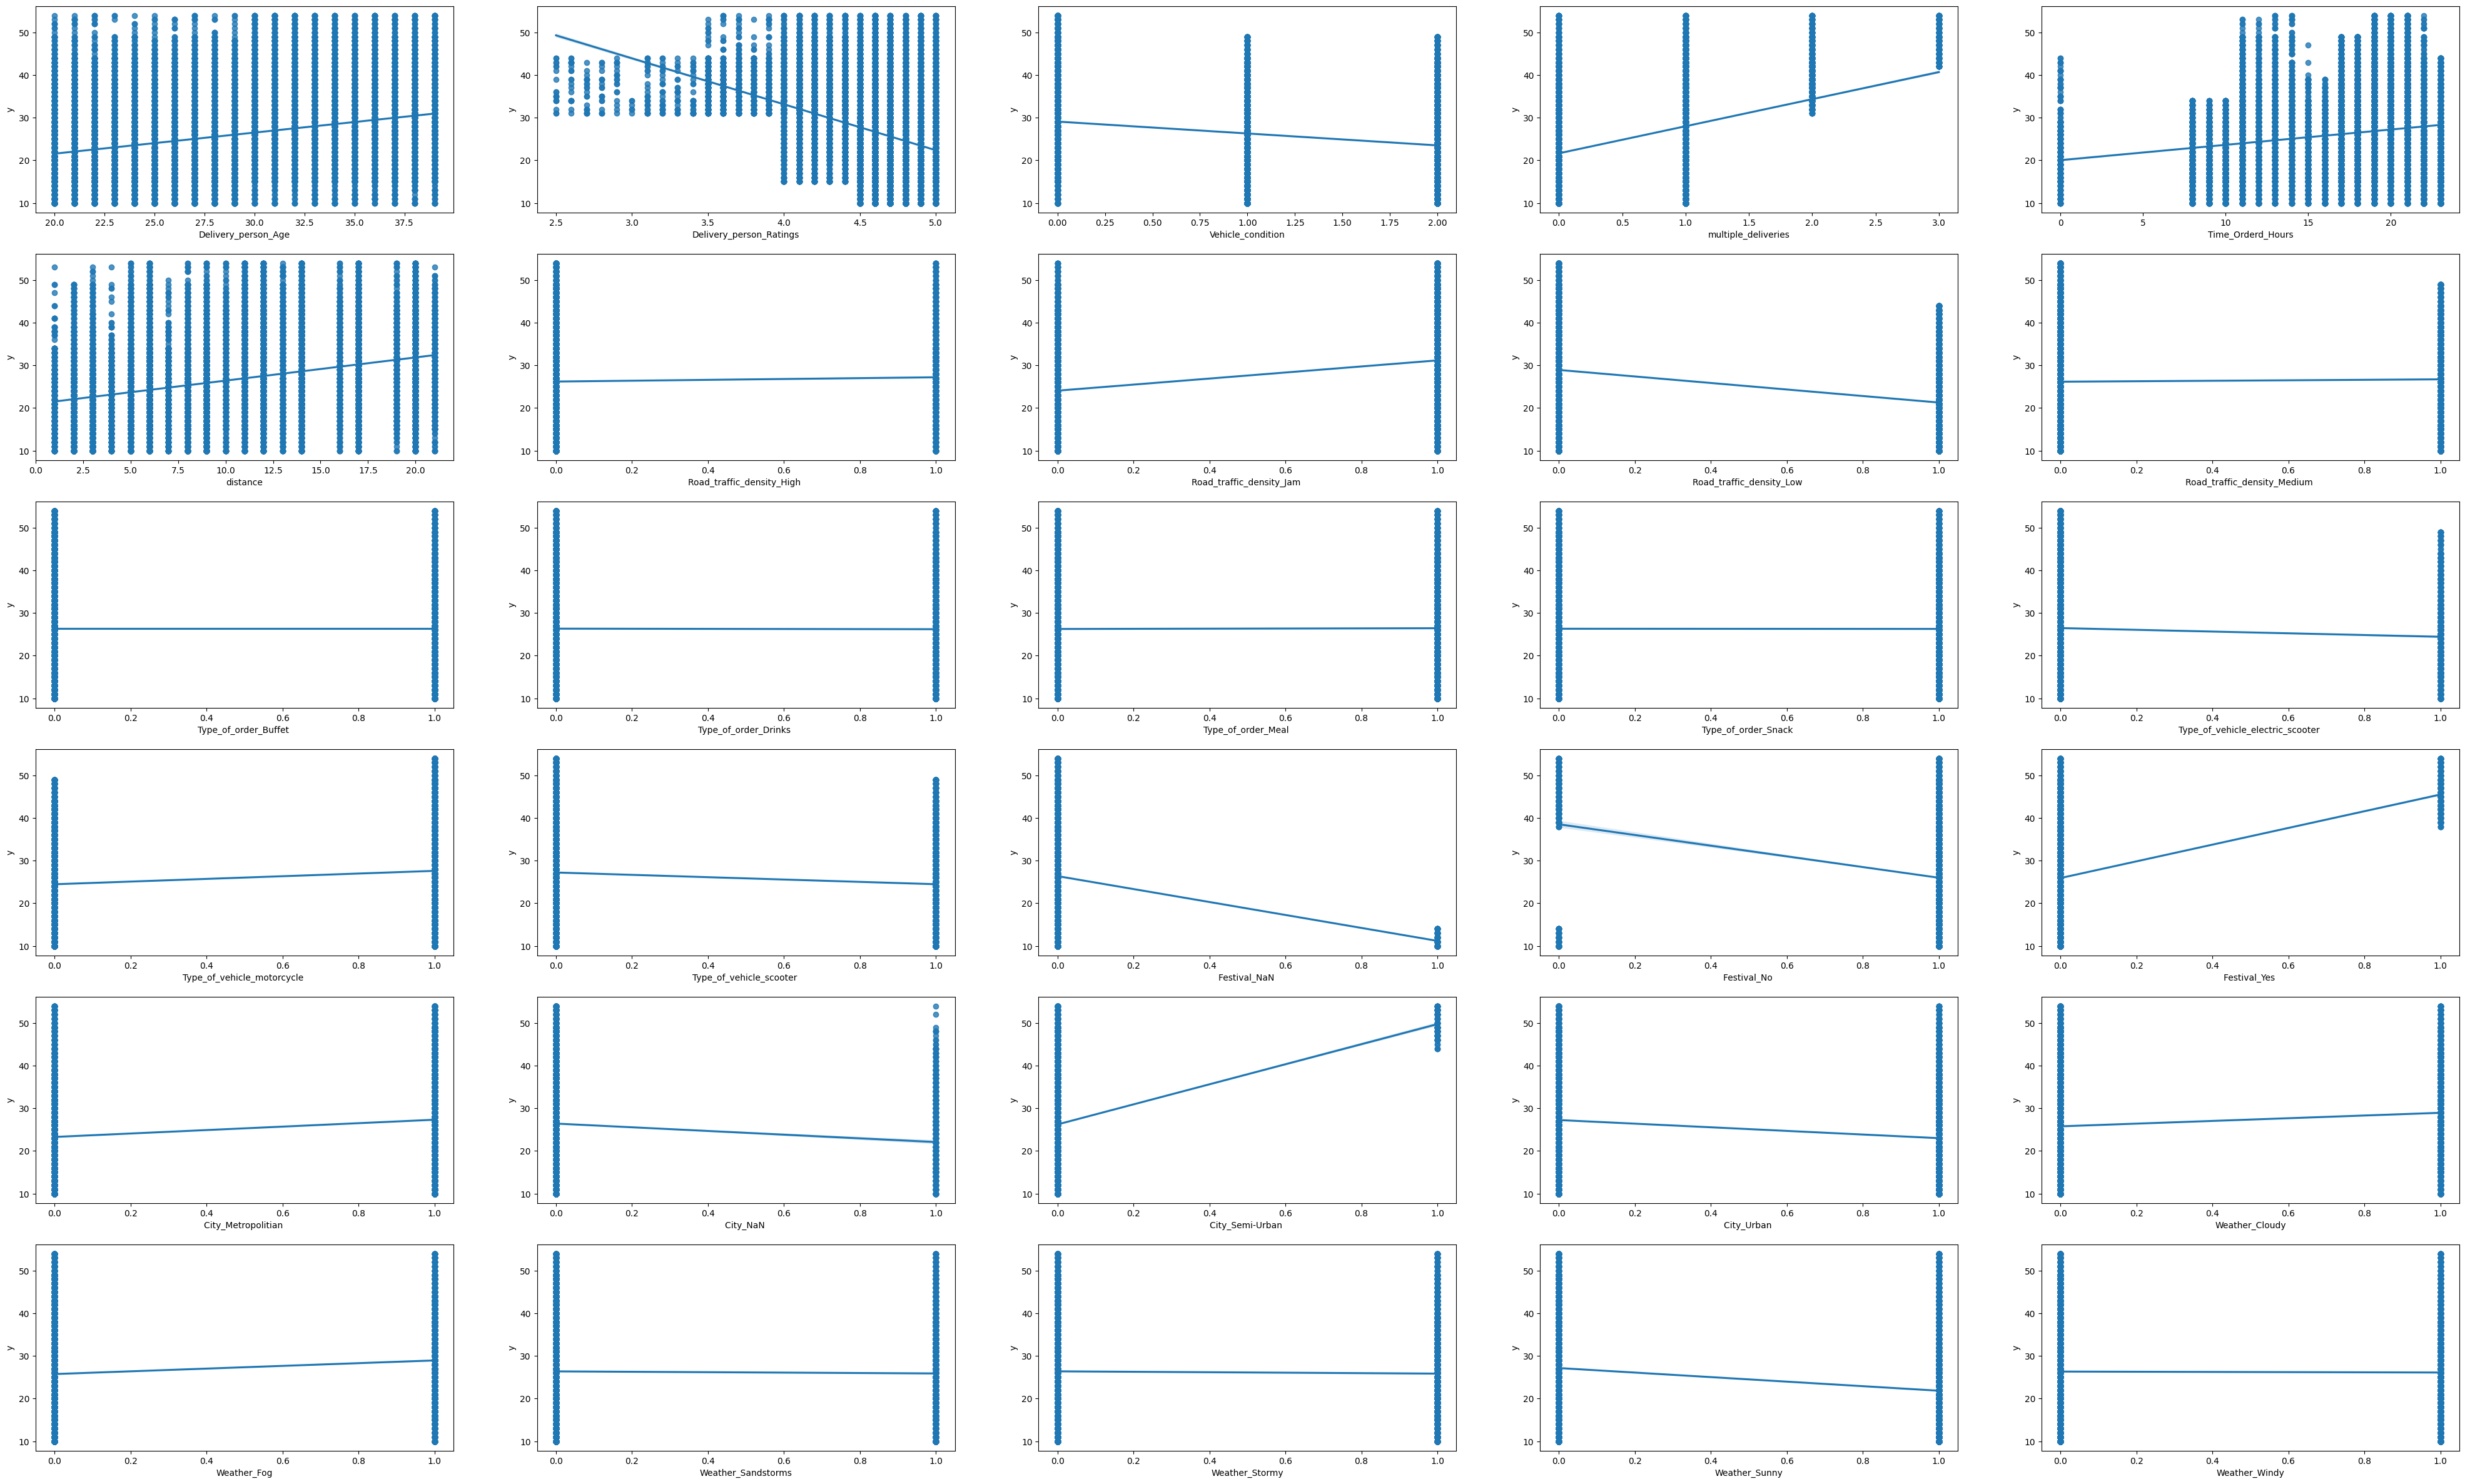

In [ ]:
# 2개의 행과 4개의 열을 가진 subplots를 이용, axs 는 4*2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(50,30), ncols = 5, nrows=6)

for i, feature in enumerate(lm_features):
  row = int(i/5)
  col = i%5
  #시본의 regplot을 이용해 산점도롸 선형 회귀 직전을 함께 표현
  sns.regplot(x=feature, y='y', data = fd, ax =axs[row][col])


In [ ]:
fd.to_csv('/content/drive/MyDrive/Food_delivery_encoding.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
fd = pd.read_csv("/content/drive/MyDrive/Food_delivery_encoding.csv")
fd.shape

(43706, 35)

In [ ]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43706 entries, 0 to 43705
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Delivery_person_ID                 43706 non-null  object 
 1   Delivery_person_Age                43492 non-null  float64
 2   Delivery_person_Ratings            43443 non-null  float64
 3   Order_Date                         43706 non-null  object 
 4   Time_Orderd                        43706 non-null  object 
 5   Time_Order_picked                  43706 non-null  object 
 6   Vehicle_condition                  43706 non-null  int64  
 7   multiple_deliveries                42765 non-null  float64
 8   y                                  43706 non-null  int64  
 9   Time_Orderd_Hours                  43706 non-null  int64  
 10  distance                           43706 non-null  float64
 11  Road_traffic_density_High          43706 non-null  int

In [ ]:
fd.drop(['Delivery_person_ID','Time_Orderd','Time_Order_picked','Order_Date'], axis=1, inplace=True)
fd.shape

(43706, 31)

In [ ]:
fd = fd.dropna()
fd.shape

(42512, 31)

In [ ]:
fd.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,42512.0,29.569298,5.763488,20.0,25.0,30.0,35.0,39.0
Delivery_person_Ratings,42512.0,4.634623,0.314440,2.5,4.5,4.7,4.9,5.0
Vehicle_condition,42512.0,0.999506,0.816962,0.0,0.0,1.0,2.0,2.0
multiple_deliveries,42512.0,0.743743,0.572933,0.0,0.0,1.0,1.0,3.0
y,42512.0,26.373871,9.374550,10.0,19.0,26.0,32.0,54.0
Time_Orderd_Hours,42512.0,17.429502,4.810983,0.0,15.0,19.0,21.0,23.0
distance,42512.0,9.795446,5.552733,1.0,5.0,9.0,14.0,21.0
Road_traffic_density_High,42512.0,0.098654,0.298201,0.0,0.0,0.0,0.0,1.0
Road_traffic_density_Jam,42512.0,0.315652,0.464781,0.0,0.0,0.0,1.0,1.0
Road_traffic_density_Low,42512.0,0.341668,0.474275,0.0,0.0,0.0,1.0,1.0


## train, test split

In [ ]:
X = fd.drop('y',axis=1) #features
y = fd['y'] # target variable

# split the data into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(34009, 30)
(34009,)
(8503, 30)
(8503,)


## 모델

1. 교차 검증 및 하이퍼파라미터 튜닝을 사용하여 최적의 회귀 모델을 결정합니다.
2. 배달 예측 모델을 식별된 최상의 모델을 사용하여 구축합니다.
3. 테스트 데이터에서 모델의 성능을 평가하여 정확성과 신뢰성을 평가합니다.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
def cross_val_rmse(model):
    neg_rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-neg_rmse_scores)

    for iter_count, rmse in enumerate(rmse_scores):
        print('교차검증 {0} RMSE 값: {1:.4f}'.format(iter_count, rmse))
    print('평균 RMSE 값: {0:.4f}'.format(np.mean(rmse_scores)))
    return model

In [ ]:
pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 114.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.1 which is incompatible.


In [ ]:
from pygam import LinearGAM

gam = LinearGAM()
gam.fit(X_train, y_train)
gam_pred = gam.predict(X_test)
gam_rmse = np.sqrt(mean_squared_error(y_test, gam_pred))
gam_r2 = r2_score(y_test, gam_pred)
print('gam Test RMSE: {:.4f}, R^2: {:.4f}'.format(gam_rmse,gam_r2))

gam Test RMSE: 5.3145, R^2: 0.6726


In [ ]:
# lasso model
alpha =[0.07,0.1,0.5,1,3]
for i in alpha:
  lasso_reg = Lasso(alpha=i)
  lasso_reg.fit(X_train, y_train)
  lasso_pred = lasso_reg.predict(X_test)
  lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
  lasso_r2 = r2_score(y_test, lasso_pred)
  print('alpha:'+str(i)+' >  Lasso Regression Test RMSE: {:.4f}, R^2: {:.4f}'.format(lasso_rmse, lasso_r2))


alpha:0.07 >  Lasso Regression Test RMSE: 5.9826, R^2: 0.5851
alpha:0.1 >  Lasso Regression Test RMSE: 6.0230, R^2: 0.5795
alpha:0.5 >  Lasso Regression Test RMSE: 6.7689, R^2: 0.4689
alpha:1 >  Lasso Regression Test RMSE: 7.5500, R^2: 0.3393
alpha:3 >  Lasso Regression Test RMSE: 8.3688, R^2: 0.1882


In [ ]:
lasso_reg = Lasso(alpha=0.07)
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_r2 = r2_score(y_test, lasso_pred)
print('Lasso Regression Test RMSE: {:.4f}, R^2: {:.4f}'.format(lasso_rmse, lasso_r2))

Lasso Regression Test RMSE: 5.9826, R^2: 0.5851


In [ ]:
cross_val_rmse(lasso_reg)

교차검증 0 RMSE 값: 5.9810
교차검증 1 RMSE 값: 6.0528
교차검증 2 RMSE 값: 5.9871
교차검증 3 RMSE 값: 5.9425
교차검증 4 RMSE 값: 6.0361
평균 RMSE 값: 5.9999


Lasso(alpha=0.07)

In [ ]:
# NN model
nn_reg = MLPRegressor(random_state=11, max_iter=500)
nn_reg.fit(X_train, y_train)
nn_pred = nn_reg.predict(X_test)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred))
nn_r2 = r2_score(y_test, nn_pred)
print('Neural Network Test RMSE: {:.4f}, R^2: {:.4f}'.format(nn_rmse, nn_r2))

Neural Network Test RMSE: 4.1581, R^2: 0.7996


In [ ]:
#cross_val(nn_reg)

In [ ]:
# XGBoost 모델
xgb_reg = XGBRegressor(random_state=11)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)
print('XGBoost Test RMSE: {:.4f}, R^2: {:.4f}'.format(xgb_rmse, xgb_r2))

XGBoost Test RMSE: 3.7327, R^2: 0.8385


In [ ]:
cross_val_rmse(xgb_reg)

교차검증 0 RMSE 값: 3.7553
교차검증 1 RMSE 값: 3.7975
교차검증 2 RMSE 값: 3.7553
교차검증 3 RMSE 값: 3.7442
교차검증 4 RMSE 값: 3.7313
평균 RMSE 값: 3.7567


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=11, ...)

In [ ]:
# 랜덤 포레스트 모델
rf_reg = RandomForestRegressor(random_state=11)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print('Random Forest Test RMSE: {:.4f}, R^2: {:.4f}'.format(rf_rmse, rf_r2))

Random Forest Test RMSE: 3.7996, R^2: 0.8327


In [ ]:
cross_val_rmse(rf_reg)

교차검증 0 RMSE 값: 3.8228
교차검증 1 RMSE 값: 3.8738
교차검증 2 RMSE 값: 3.8307
교차검증 3 RMSE 값: 3.8601
교차검증 4 RMSE 값: 3.8280
평균 RMSE 값: 3.8431


RandomForestRegressor(random_state=11)

In [ ]:
from lightgbm import LGBMRegressor

# LightGBM 모델 정의
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
lgbm_r2 = r2_score(y_test, lgbm_pred)

print('LightGBM Test RMSE: {:.4f}, R^2: {:.4f}'.format(lgbm_rmse, lgbm_r2))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 34009, number of used features: 30
[LightGBM] [Info] Start training from score 26.383428
LightGBM Test RMSE: 3.6984, R^2: 0.8415


In [ ]:
cross_val_rmse(lgbm_reg)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 34009, number of used features: 30
[LightGBM] [Info] Start training from score 26.330501
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 34009, number of used features: 30
[LightGBM] [Info] Start training from score 26.389073
[LightGBM] [Warning] Found w

LGBMRegressor(random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# K-최근접 이웃 모델
knn_reg = KNeighborsRegressor(n_neighbors=5)  # 여기서 5는 이웃의 수입니다. 적절한 값으로 조정 가능
knn_reg.fit(X_train, y_train)
knn_pred = knn_reg.predict(X_test)

# 성능 평가
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
knn_r2 = r2_score(y_test, knn_pred)
print('K-Nearest Neighbors Test RMSE: {:.4f}, R^2: {:.4f}'.format(knn_rmse, knn_r2))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e3960ba0c10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cannot open shared object file: No such file or directory


K-Nearest Neighbors Test RMSE: 5.3015, R^2: 0.6742


In [ ]:
cross_val_rmse(knn_reg)

교차검증 0 RMSE 값: 5.3589
교차검증 1 RMSE 값: 5.3653
교차검증 2 RMSE 값: 5.4004
교차검증 3 RMSE 값: 5.3141
교차검증 4 RMSE 값: 5.3865
평균 RMSE 값: 5.3650


KNeighborsRegressor()

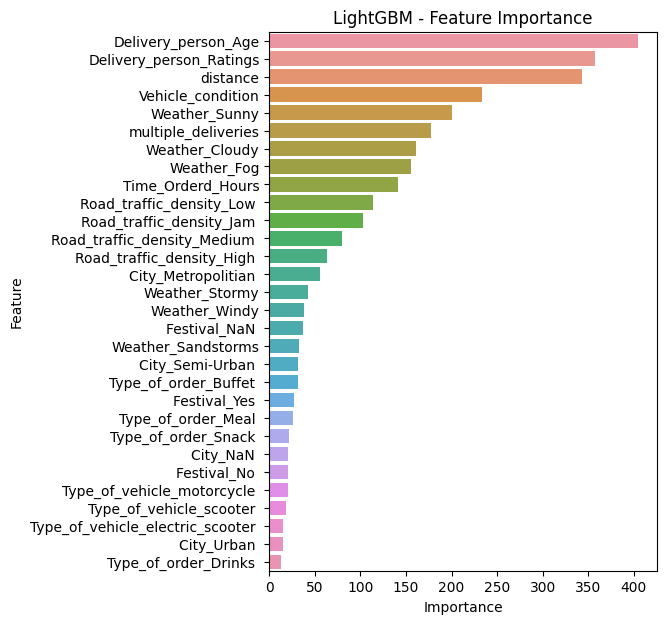

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델의 feature importance 얻기
feature_importance = lgbm_reg.feature_importances_

# 각 변수와 그에 대한 중요도를 묶기
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# 중요도에 따라 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(5, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('LightGBM - Feature Importance')
plt.show()
